# Tutorial 3: Circuit Cutting with Quantum Serverless

**Circuit cutting** is a technique to decompose a quantum circuit into smaller circuits, whose results can be knitted together to reconstruct the original circuit output. 

The circuit knitting toolbox implements a wire cutting method presented in [CutQC](https://doi.org/10.1145/3445814.3446758) (Tang et al.). This method allows a circuit wire to be cut such that the generated subcircuits are amended by measurements in the Pauli bases and by state preparation of four Pauli eigenstates (see Fig. 4 of [CutQC](https://doi.org/10.1145/3445814.3446758)).

This wire cutting technique is comprised of the following basic steps:

1. **Decompose**: Cut a circuit into multiple subcircuits. Here, we'll use an automatic method to find optimal cut(s). See [tutorial 2](tutorial_2_manual_cutting.ipynb) to manually cut a circuit.
2. **Evaluate**: Execute those subcircuits on quantum backend(s).
3. **Reconstruct**: Knit the subcircuit results together to reconstruct the original circuit output (in this case, the full probability distribution).

[**Quantum Serverless**](https://github.com/Qiskit-Extensions/quantum-serverless) is a platform built to enable distributed computing across a variety of classical and quantum backends.

In this demo, we will show how to use quantum serverless to run portions of this workflow on a remote cluster.

## Create a quantum circuit with Qiskit

In this case, we'll create a hardware-efficient circuit (`EfficientSU2` from the Qiskit circuit library) with two (linear) entangling layers.

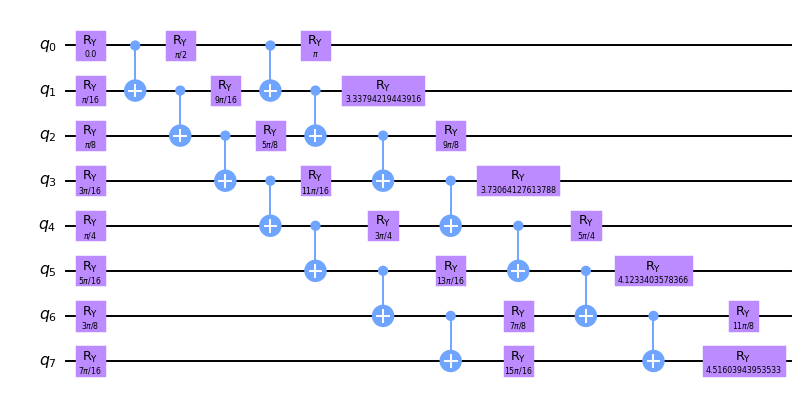

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2

num_qubits = 8
circuit = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="linear",
    su2_gates=["ry"],
)

circuit = circuit.decompose()

params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
circuit = circuit.bind_parameters(params)
circuit.draw("mpl", fold=-1, scale=0.7)

## Set up Quantum Serverless

We can use Quantum Serverless to allocate the steps of wire cutting to various compute resources. For this tutorial, we will use our local CPU cores as our cluster. See the [Quantum Serverless](https://github.com/Qiskit-Extensions/quantum-serverless) documentation (and below) for more informatin about how to use other clusters.

In [2]:
from quantum_serverless import QuantumServerless, get

serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

## Decompose the circuit with wire cutting 

### Use `quantum-serverless` to send the `cut_circuit_wires` method to a remote cluster

Here we create a wrapper function for the `cut_circuit_wires` function and annotate it with the `@run_qiskit_remote()` decorator from `quantum-serverless`. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [3]:
from typing import Optional, Sequence, Any, Dict
from nptyping import NDArray
from qiskit import QuantumCircuit
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires
from quantum_serverless import run_qiskit_remote, get

# Create a wrapper function to be sent to remote cluster
@run_qiskit_remote()
def cut_circuit_wires_remote(
    circuit: QuantumCircuit,
    method: str,
    subcircuit_vertices: Optional[Sequence[Sequence[int]]] = None,
    max_subcircuit_width: Optional[int] = None,
    max_subcircuit_cuts: Optional[int] = None,
    max_subcircuit_size: Optional[int] = None,
    max_cuts: Optional[int] = None,
    num_subcircuits: Optional[Sequence[int]] = None,
) -> Dict[str, Any]:
    return cut_circuit_wires(
        circuit=circuit,
        method=method,
        subcircuit_vertices=subcircuit_vertices,
        max_subcircuit_width=max_subcircuit_width,
        max_subcircuit_cuts=max_subcircuit_cuts,
        max_subcircuit_size=max_subcircuit_size,
        max_cuts=max_cuts,
        num_subcircuits=num_subcircuits,
    )

### Decompose the circuit in a serverless context

In this example, we will use an automatic method to find cuts matching our criteria. See [tutorial 1](tutorial_1_automatic_cut_finding.ipynb) for how to configure the inputs for the automatic method. See [tutorial 2](tutorial_2_manual_cutting.ipynb) for how to manually cut a circuit.
   
We will call the `cut_circuit_wires_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, the default cluster for this demo will use the cores on our local CPU. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function from `quantum-serverless` is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [4]:
with serverless:
    cuts_future = cut_circuit_wires_remote(
        circuit=circuit,
        method="automatic",
        max_subcircuit_width=5,
        max_cuts=2,
        num_subcircuits=[2],
    )
    cuts = get(cuts_future)

(cut_circuit_wires_remote pid=85257) Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
(cut_circuit_wires_remote pid=85257) Version identifier: 22.1.0.0 | 2022-03-27 | 54982fbec
(cut_circuit_wires_remote pid=85257) CPXPARAM_Read_DataCheck                          1
(cut_circuit_wires_remote pid=85257) CPXPARAM_TimeLimit                               300
(cut_circuit_wires_remote pid=85257) Warning:  Non-integral bounds for integer variables rounded.
(cut_circuit_wires_remote pid=85257) Tried aggregator 3 times.
(cut_circuit_wires_remote pid=85257) MIP Presolve eliminated 37 rows and 8 columns.
(cut_circuit_wires_remote pid=85257) MIP Presolve modified 7 coefficients.
(cut_circuit_wires_remote pid=85257) Aggregator did 103 substitutions.
(cut_circuit_wires_remote pid=85257) Reduced MIP has 366 rows, 127 columns, and 1072 nonzeros.
(cut_circuit_wires_remote pid=85257) Reduced MIP has 121 binaries, 6 generals, 0 SOSs, and 0 indicators.
(cut_circu

/Users/caleb/opt/anaconda3/envs/ckt/lib/python3.9/site-packages/ray/_private/worker.py:976: UserWarning: len(ctx) is deprecated. Use len(ctx.address_info) instead.
  warnings.warn("len(ctx) is deprecated. Use len(ctx.address_info) instead.")


### The two subcircuits produced

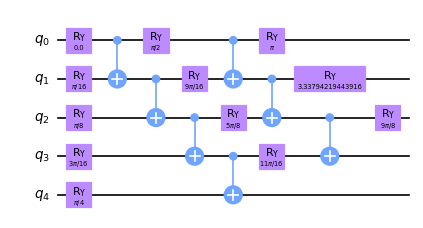

In [5]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl", fold=-1, scale=0.6)

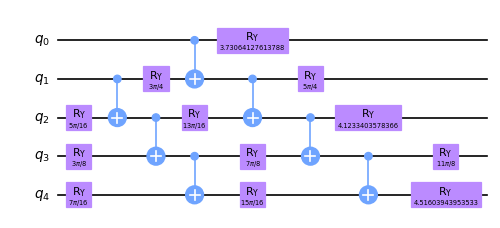

In [6]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl", fold=-1, scale=0.6)

## Evaluate the subcircuits

### Use `quantum-serverless` to send the `evaluate_subcircuits` method to a remote cluster

Here we create a wrapper function for the `evaluate_subcircuits` function and annotate it with the `@run_qiskit_remote()` decorator from `quantum-serverless`. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [7]:
from qiskit_ibm_runtime import Options
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import evaluate_subcircuits

# Create a wrapper function to be sent to remote cluster
@run_qiskit_remote()
def evaluate_subcircuits_remote(
    cuts: Dict[str, Any],
    service_args: Optional[Dict[str, Any]] = None,
    backend_names: Optional[Sequence[str]] = None,
    options_dict: Optional[Dict] = None,
) -> Dict[int, Dict[int, NDArray]]:
    service = None if service_args is None else QiskitRuntimeService(**service_args)
    options = None if options_dict is None else Options(**options_dict)

    return evaluate_subcircuits(
        cuts, service=service, backend_names=backend_names, options=options
    )

### Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to IBM Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.
Alternatively, a local statevector simulator can be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html).

In [8]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime.
# service = QiskitRuntimeService()

### Configure the Qiskit Runtime Primitive

The wire cutter tool uses a `Sampler` primitive to evaluate the probabilities of each subcircuit. Here, we configure the options for the Runtime Sampler and specify the backend(s) to be used to evaluate the subcircuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems). In this tutorial, two local cores will be used to support each of the parallel backend threads we'll specify below.

If no service was set up, the `backend_names` argument will be ignored, and Qiskit Primitives will be used with statevector simulator.

In [9]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

### Evaluate the subcircuits on the quantum backend(s)

We will call the `evaluate_subcircuits_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, our local CPU is the default cluster for this demo. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function from `quantum-serverless` is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [10]:
from dataclasses import asdict

with serverless:
    # QiskitRuntimeService is not serializable, so we must convert it to a dictionary before passing to remote function
    service_args = None if service is None else service.active_account()

    # The Options class is not serializable, so we must convert it to a dictionary before passing to remote function
    options_dict = asdict(options)

    subcircuit_probabilities_future = evaluate_subcircuits_remote(
        cuts,
        service_args=service_args,
        backend_names=backend_names,
        options_dict=options_dict,
    )
    subcircuit_instance_probabilities = get(subcircuit_probabilities_future)

## Reconstruct the full circuit output

### Use `quantum-serverless` to send the `reconstruct_full_distribution` method to a remote cluster

Next, the results of the subcircuit experiments are classically postprocessed to reconstruct the original circuit's full probability distribution.

Here, we create a wrapper function for the `reconstruct_full_distribution` function and annotate it with the `@run_qiskit_remote()` decorator from `quantum-serverless`. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [11]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import (
    reconstruct_full_distribution,
)


@run_qiskit_remote()
def reconstruct_full_distribution_remote(
    circuit: QuantumCircuit,
    subcircuit_instance_probabilities: Dict[int, Dict[int, NDArray]],
    cuts: Dict[str, Any],
    num_threads: int = 1,
) -> NDArray:
    return reconstruct_full_distribution(
        circuit, subcircuit_instance_probabilities, cuts
    )

### Reconstruct the output

We will call the `reconstruct_full_distribution_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, our local CPU is the default cluster for this demo. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function from `quantum-serverless` is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [12]:
%%capture

with serverless:
    reconstructed_probabilities_future = reconstruct_full_distribution_remote(
        circuit, subcircuit_instance_probabilities, cuts
    )
    reconstructed_probabilities = get(reconstructed_probabilities_future)

## Verify the results

If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's exact probability distribution (ground truth).

In [13]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import verify

metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

### The verify step includes several metrics

For example, the chi square loss is computed. Since we're using the Qiskit Sampler with statevector simulator, we expect the reconstructed distributed to exactly match the ground truth. More info about each metric can be found in the [utils metrics file](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/circuit_knitting_toolbox/utils/metrics.py).

In [14]:
metrics

{'nearest': {'chi2': 0.014781577189785336,
  'Mean Squared Error': 3.607494186206942e-07,
  'Mean Absolute Percentage Error': 78992.90552703604,
  'Cross Entropy': 3.6842346725058057,
  'HOP': 0.9934651038602943},
 'naive': {'chi2': 0.014293570101341663,
  'Mean Squared Error': 3.7810267377915685e-07,
  'Mean Absolute Percentage Error': 80793.04233599117,
  'Cross Entropy': 3.6693264359537037,
  'HOP': 0.9915340741625416}}

### Visualize both distributions

If we calculated the ground truth above, we can visualize a comparison to the reconstructed probabilities

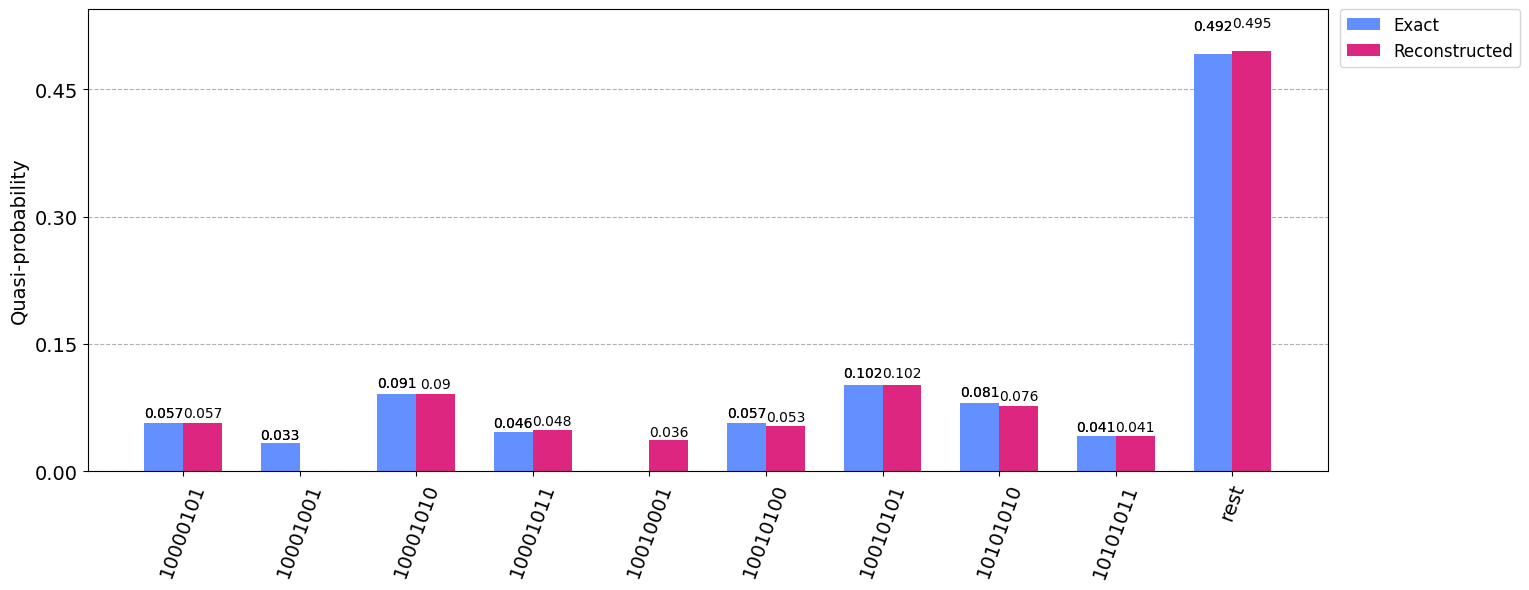

In [15]:
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

In [16]:
import qiskit.tools.jupyter

%qiskit_version_table

This code is a Qiskit project.
© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.